In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

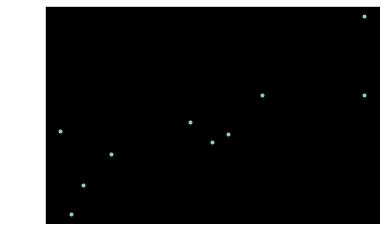

In [45]:
# generate data
n = 10
a = 0.1
b = 0.25
scale = 0.5
x = np.random.normal(0, 1, n)
y = a + b*x + np.random.normal(0, scale, n)
plt.plot(x, y, '.')
plt.show()

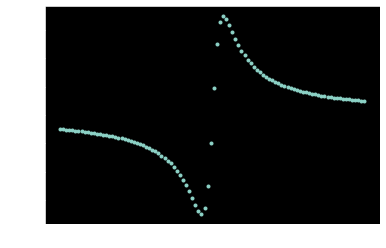

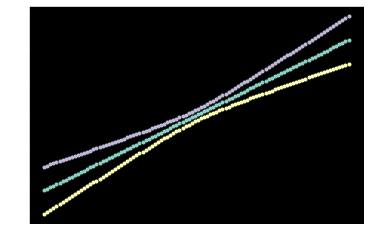

In [65]:
# bayesian inference

class BayesLinRegr:
    def __init__(self, kelly_std:float = 1, max_w:float = 1, intercept:bool = True):
        self.kelly_std = kelly_std
        self.max_w = max_w
        self.intercept = intercept
        # need to be estimated
        self.a, self.b, self.w, self.V = None, None, None, None
        self.w_norm = 1
        
    def view(self):
        print('Bayesian Linear Regression NIG params')
        print('wn')
        print(self.w)
        print('Vn')
        print(self.V)
        print('an, bn = ', self.a, self.b)
        print('E[sigma^2] = ', self.b / (self.a - 1))
        print('E[sigma] = ', np.sqrt(self.b / (self.a - 1)))
    
    def estimate(self, y, x, **kwargs):
        if y.ndim == 2: assert y.shape[1] == 1, "y must contain a single variable"
        y = y.ravel()
        x = np.atleast_2d(x.T).T
        n = y.size
        if self.intercept:
            x = np.hstack((np.ones((n, 1)), x))
        n, p = x.shape

        # prior for w
        w0 = np.zeros(p) # this makes sense
        V0 = np.eye(p) # find a better way to estimate this one
        # prior for sigma^2
        v = np.var(y)
        k = 5
        a0 = 2 # prior with infinite variance
        b0 = v*(a0 - 1)
        invV0 = np.linalg.inv(V0)
        invVn = invV0 + x.T @ x         
        self.V = np.linalg.inv(invVn)
        self.w = self.V @ (x.T @ y + invV0 @ w0)
        self.a = a0 + n / 2
        self.b = b0 + 0.5*(w0.T @ invV0 @ w0 + np.dot(y,y) - self.w.T @ invVn @ self.w)
    
        # compute w norm
        # normalization must be computed without
        # second non central moment otherwise weight
        # goes to zero for large moves
        x_move = np.mean(x, axis = 0) + self.kelly_std * np.std(x, axis = 0)
        mean_move = np.dot(np.abs(self.w), x_move)
        var_move = self.b/(self.a - 1)        
        w_move = mean_move / var_move
        self.w_norm = w_move
    
    def posterior_predictive(self, xq, **kwargs):
        '''
        approximate with normal
        '''
        if not isinstance(xq, np.ndarray):
            xq = np.array(xq)
        xq = np.atleast_2d(xq)[-1]
        if self.intercept: xq = np.hstack((0, xq))
        mean = np.dot(self.w, xq)
        var = self.b*(1 + np.dot(xq, np.dot(self.V, xq)))/(self.a - 1)
        return mean, var
    
    def get_weight(self, xq, **kwargs):
        m, v = self.posterior_predictive(xq)
        w = m / (v + m*m)
        w /= self.w_norm
        if np.abs(w) > self.max_w:
            w = np.sign(w) * self.max_w
        return w
    
regr = BayesLinRegr()
regr.estimate(y, x)   

x_values = np.linspace(-10, 10, 100)

y_est = np.zeros_like(x_values)
std_est = np.zeros_like(x_values)
w_est = np.zeros_like(x_values)

for i in range(x_values.size):
    m, v = regr.posterior_predictive(x_values[i])
    y_est[i] = m
    std_est[i] = np.sqrt(v)
    w_est[i] = regr.get_weight(x_values[i])
    
plt.plot(x_values, w_est, '.')
plt.show()

plt.plot(x_values, y_est, '.')
plt.plot(x_values, y_est - std_est, '.')
plt.plot(x_values, y_est + std_est, '.')
plt.show()


In [21]:
type(np.array([1,2])[0])


#np.atleast_2d()


numpy.int32